## NetREX+ on yeast data with changes to C matrix

In [63]:
#NETREX
#needed for package

import numpy as np
import pandas as pd
import sys
from implicit import als
import math
import cvxopt
from scipy.linalg import fractional_matrix_power, block_diag
from pylab import *
from cvxpy import *
import argparse
import mosek
from scipy.sparse import csr_matrix
import copy


#testing
import warnings
#netrex

class NetREX: 
    #init
    def __init__(self, E, C, lambda_, theta=1, alpha=10, iternum = 300, p = 30, solver = ECOS):
        #parameters
        self.theta = theta # scalar > 0
        self.alpha = alpha
        self.xbound = 1.0
        self.ybound = 1.0
        self.iternum = iternum
        self.lambda_ = lambda_ #parameter matrix
        #read in exp, read prior data 
        #self.ReadExp(ExpFile) #get ExpMat from this
        self.ExpMat = E #expression for now
        self.C = 1+ 40*C #matrix of confidences (weights)
        self.NumGene = E.shape[0]
        self.NumTF = C.shape[1]
        self.NumExp = E.shape[1]
        #parameter matrix eta
        self.eta = self.C + theta
        self.i_ = range(self.NumGene) #range of i
        self.j_ = range(self.NumTF) #range of j 
        #controls amount of factors in xi/yj
        self.p = p
        #set solver
        self.solver = solver
        
    #Put read in exp here later
    
    #initialization
    def initialization(self):
        #!!! other parameters!!!
        #Use implicit package for CF problems to initialize X & Y: 
        implicit_model = als.AlternatingLeastSquares(factors=self.p)
        #add to get new weight matrix
        #C_adj = 1 + 40*self.C
        #self.C = C_adj
    
        
        #train model on weight matrix
        #implicit_model.fit(csr_matrix(C_cutoff))
        implicit_model.fit(csr_matrix(self.C))
        #initial X (matrix of xi vectors)
        self.X = implicit_model.item_factors.T
        for i in self.i_:
            TmpNorm = np.linalg.norm(self.X[:,i])
            if TmpNorm < 1E-5:
                continue
            self.X[:,i] = self.X[:,i] / TmpNorm
        np.nan_to_num(self.X, copy=False)
        #initial Y (matrix of yj vectors)
        self.Y = implicit_model.user_factors.T
        for j in self.j_:
            TmpNorm = np.linalg.norm(self.Y[:,j])
            if TmpNorm < 1E-5:
                continue
            self.Y[:,j] = self.Y[:,j] / TmpNorm
        np.nan_to_num(self.Y, copy=False)
        
        #set initial S to C
        #self.S = copy.deepcopy(self.C)
        #binarize S to use for finding A 
        #S_init = (self.S > 0).astype(int)
        #initialize A using NetREX 1 closed form
        #!!!!!Other options!!!!!
        #Abound = 1.0
        #self.A = np.linalg.inv(S_init.T.dot(S_init)+np.eye(self.NumTF)).dot(S_init.T).dot(self.ExpMat)
        #self.A = np.multiply((np.absolute(Atmp)<=Abound), Atmp) + \
                                       # np.multiply((np.absolute(Atmp)>Abound), np.sign(Atmp)*Abound)
        
        #try using NCA to get initial A
        self.A = self.NCA_()
        
        #initial Uk
        mu_S = np.linalg.norm(self.A.dot(self.A.T), 'fro')
        Uk = self.S - (2./mu_S)*(self.S.dot(self.A).dot(self.A.T) - self.ExpMat.dot(self.A.T))
        #initial S 
        c = np.sqrt((2./mu_S)*(self.alpha*self.lambda_*np.square(np.ones([self.NumGene,self.NumTF]) -
                                                          self.X.T.dot(self.Y)) + self.eta))  
        Sequal = np.where(np.absolute(Uk) == c, c*np.random.randint(2, size=(self.NumGene,self.NumTF)), 0)
        Sgreater = np.where(np.absolute(Uk) > c, Uk, 0)
        self.S = Sequal + Sgreater
        
        plt.figure(1, figsize=(8, 8))
        ax1 = plt.subplot(211)
        ax1.imshow(self.S)
        ax2 = plt.subplot(212)
        ax2.imshow(self.X.T.dot(self.Y))
        plt.show() 
    
    #try to program iterative NCA
    def NCA_(self):
        #set initial S to C
        self.S = copy.deepcopy(self.C)
        #binarize S to use for finding A 
        S_init = (self.S > 0).astype(int).astype(float)
        for k in range(50):
            A_init = np.linalg.inv(S_init.T.dot(S_init)+ 0.1*np.eye(self.NumTF)).dot(S_init.T).dot(self.ExpMat)
            # update S
            for i in range(self.NumGene):
                Indn0 = np.where(self.S[i,:]!=0)[0]
                Et = self.ExpMat[i,:]
                At = A_init[Indn0,:]
                St = Et.dot(At.T).dot(np.linalg.inv(At.dot(At.T)+0.1*np.eye(At.shape[0])))
                S_init[i,Indn0] = St 
            
        return A_init
        
    #Define the objective function 
    def ObjFunction(self):
        S_0 = (self.S != 0).astype(int) 
        self.a_ = self.lambda_*(self.C + self.alpha*S_0)
        W = np.sqrt(self.a_) 
        Val = np.linalg.norm(self.ExpMat - self.S.dot(self.A), 'fro')**2 +np.linalg.norm(W*(S_0 - self.X.T.dot(self.Y)),
                    'fro')**2 + np.linalg.norm(np.sqrt(self.eta*S_0), 'fro')**2
        return Val
    
    def PALM_A(self):
        mu_A = np.linalg.norm(self.S.T.dot(self.S), 'fro')
        #solution for A
        self.A = (np.linalg.inv((2./mu_A)*self.S.T.dot(self.S)+ np.identity(self.NumTF))).dot(((2./mu_A) * 
                                                                self.ExpMat.T.dot(self.S) + self.A.T).T) 
        
    def PALM_S(self):
        mu_S = np.linalg.norm(self.A.dot(self.A.T), 'fro')
        Uk = self.S - (2./mu_S)*(self.S.dot(self.A).dot(self.A.T) - self.ExpMat.dot(self.A.T))
        c = np.sqrt((2./mu_S)*(self.alpha*self.lambda_*np.square(np.ones([self.NumGene,self.NumTF]) -
                                                          self.X.T.dot(self.Y)) + self.eta))
        '''
        plt.figure(1, figsize=(8, 3))
        ax1 = plt.subplot(211)
        ax1.imshow(c)
        ax2 = plt.subplot(212)
        ax2.imshow(Uk)
        plt.show() 
        
        print(c[30:, 0:20])
        print(Uk[30:, 0:20])
        '''
        
        #solution for S   
        Sequal = np.where(np.absolute(Uk) == c, c*np.random.randint(2, size=(self.NumGene,self.NumTF)), 0)
        Sgreater = np.where(np.absolute(Uk) > c, Uk, 0)
        self.S = Sequal + Sgreater
        #print(self.S)
        self.S_0 = (self.S != 0).astype(int)
    
    def solve_qcqp(self, phi, varphi): 
        '''
        Use cvxpy to solve the problem: 
        min x^T*phi*x + varphi*x
        s.t. to norm(x) <= 1
        (problem is the same for y)
        '''
        x = Variable(self.p)
        P = (phi/10.).astype(np.double) #this is phi modified for cvxpy
        q = (varphi/10.).astype(np.double) #varphi modified for cvxpy
        
        #print(P, q)
        objective = Minimize(quad_form(x,P) - q.T*x)
        constraints = [square(norm(x)) <= 1]
        
        prob = Problem(objective, constraints)
        
        try:
            result = prob.solve(solver=self.solver)
            return x.value
        except:
            print(P, q)
            prob.solve(verbose=True)
            
            
           
    def PALM_x(self):
        #define variables for matrix formulation
        for i in self.i_: 
            x = self.X[:,i]
            S_0 = (self.S != 0).astype(int)
            a_ = self.lambda_*(self.C + self.alpha*S_0)
            A_i = np.diag([a_[i,j] for j in self.j_])
            S_i = np.array([S_0[i,j] for j in self.j_]) 
            mu_x = np.linalg.norm(2*self.Y.dot(A_i).dot(self.Y.T), 'fro')                            
            phi = (mu_x/2)*np.identity(self.p) + self.Y.dot(A_i).dot(self.Y.T)
            varphi = 2*S_i.dot(A_i).dot(self.Y.T) + mu_x*x.T 
            self.X[:,i] = self.solve_qcqp(phi, varphi)
        
    def PALM_y(self):
        #matrix formulation
        for j in self.j_:
            y = self.Y[:,j]
            S_0 = (self.S != 0).astype(int)
            a_ = self.lambda_*(self.C + self.alpha*S_0)
            A_j = np.diag([a_[i,j] for i in self.i_])
            S_j = np.array([S_0[i,j] for i in self.i_])
            mu_y = np.linalg.norm(2*self.X.dot(A_j).dot(self.X.T), 'fro')
            phi = (mu_y/2)*np.identity(self.p) + self.X.dot(A_j).dot(self.X.T)
            varphi = 2*S_j.T.dot(A_j).dot(self.X.T) + mu_y*y.T
            #print(np.ptp(self.X.dot(A_j).dot(self.X.T)))
            #print(np.ptp(phi), np.ptp(varphi))
            #print(j, np.ptp(2*S_j.T.dot(A_j).dot(self.X.T)))
            #print(j, np.amax(y.T), np.amin(y.T))
            #print(j, mu_y)
            self.Y[:,j] = self.solve_qcqp(phi, varphi)
            
    #algorithm
    def NetREX_algorithm(self):
        self.initialization()
        conv_point = 10 #for now?  

        Valold = self.ObjFunction()
        for k in range(self.iternum): 
            self.PALM_A()
            
            '''
            plt.figure(1, figsize=(40, 30))
            ax1 = plt.subplot(211)
            ax1.imshow(self.A)
            plt.show()
            
            plt.figure(1, figsize=(40, 30))
            ax1 = plt.subplot(211)
            n, bins, patches = plt.hist(self.A.flatten(), 50, density=True, facecolor='g', alpha=0.75)
            plt.show()
            
            
            print(np.amin(self.A))
            '''
            
            self.PALM_S()
            self.PALM_x()
            self.PALM_y()
            
            '''plt.figure(1, figsize=(40, 30))
            ax1 = plt.subplot(211)
            ax1.imshow(self.S)
            ax2 = plt.subplot(212)
            ax2.imshow(self.X.T.dot(self.Y))
            plt.show() '''
        
            Valnew = self.ObjFunction()
            print("Itr %d, Obj %f" % (k, Valnew))
            check_pt = np.abs(Valold-Valnew)
            if (check_pt < conv_point) :
                print("Converge!")
                sys.stdout.flush()
                break
            Valold = Valnew
        return Valold
        
def main():
        #parser = argparse.ArgumentParser(description='netREX: network rewiring using expression')
        #define arguments
        #requiredArgs = parser.add_argument_group('required arguments')
        #requiredArgs.add_argument('-e', type=str, nargs=1, dest='expfile', required=True, metavar="expression_file",
        #                     default=None, help="<Required> Name of the expression file")
        #requiredArgs.add_argument('-c', type=str, nargs=1, dest='confidences', required=True, 
        #                metavar="confidence_matrix", default=None, help='<Required> File w matrix of confidences')
        #parser.add_argument()
    
        #parse arguments from std input
        #args=parser.parse_args()
    
        #if len(sys.argv)==1:
        #    parser.print_help(sys.stderr)
        #    sys.exit(1)
    
        #if args.expfile == None:
        #    sys.exit('missing expression data file!')
        
        #if args.confidences == None:
        #    sys.exit('missing confidence file!')
    
        #run netrex
        #tmp = NetREX(E_real, C_test, lmda_real)
        #tmp.NetREX_algorithm()
        print("Ready")
        #warnings.simplefilter('error', RuntimeWarning)

if __name__ == '__main__':
    main()

Ready


In [64]:
#get combined expression datasets


natvar = pd.read_table('../../../s2cell-prior/data/yeast_networks/expression/NatVar.txt', index_col=0)
stress = pd.read_table('../../../s2cell-prior/data/yeast_networks/expression/Stress.txt', index_col=0)
common_genes = natvar.index.intersection(stress.index)
combined = natvar.loc[common_genes].join(stress.loc[common_genes])

In [65]:
#get combined prior datasets

chip = pd.read_table('../../../s2cell-prior/data/yeast_networks/priors/ChIP_prior.txt', header=None,
                    names=['regulator','gene', 'weight'])
motif = pd.read_table('../../../s2cell-prior/data/yeast_networks/priors/Motif_prior.txt', header=None,
                    names=['regulator','gene', 'weight'])

In [66]:
print(chip.shape, motif.shape)

(245784, 3) (202926, 3)


In [67]:
chip = chip.set_index(['gene','regulator']).unstack().fillna(value=0)
#remove names
chip.columns = chip.columns.get_level_values(1)
chip.index.name = None
chip.columns.name = None

chip.head()

,MATA1,TBP,YAL011W,YAL021C,YAL043C,YAL051W,YBL002W,YBL005W,YBL008W,YBL021C,...,YPR052C,YPR054W,YPR065W,YPR068C,YPR072W,YPR086W,YPR104C,YPR133C,YPR196W,YPR199C
YAL001C,0.0,0.295455,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.529278,0.0,0.000000,0.0,0.0
YAL002W,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.335520,0.0,0.0,0.552461,0.0,0.000000,0.0,0.914234,0.0,0.0
YAL003W,0.0,0.000000,0.0,0.309524,0.0,0.0,0.0,0.0,0.0,0.0,...,0.981256,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
YAL004W,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0
YAL005C,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.794283,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0


In [68]:
motif = motif.set_index(['gene','regulator']).unstack().fillna(value=0)
#remove names
motif.columns = motif.columns.get_level_values(1)
motif.index.name = None
motif.columns.name = None

motif.head()

,MAL63,MATA1-MATALPHA2-DIMER,TBP-TFIIA,TBP-TFIIA-TFIIB,TBP-TFIIB,YAL051W,YBL005W,YBL054W,YBL103C,YBR033W,...,YPR013C,YPR015C,YPR022C,YPR052C,YPR054W,YPR065W,YPR086W,YPR104C,YPR196W,YPR199C
Q0045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.73977
Q0050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.73977
Q0055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.73977
Q0060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.73977
Q0065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.73977


In [69]:
bothprior = chip.add(motif, fill_value=0)

In [70]:
bothprior.head()

,MAL63,MATA1,MATA1-MATALPHA2-DIMER,TBP,TBP-TFIIA,TBP-TFIIA-TFIIB,TBP-TFIIB,YAL011W,YAL021C,YAL043C,...,YPR052C,YPR054W,YPR065W,YPR068C,YPR072W,YPR086W,YPR104C,YPR133C,YPR196W,YPR199C
Q0045,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,...,0.5,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.73977
Q0050,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,...,0.5,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.73977
Q0055,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,...,0.5,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.73977
Q0060,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,...,0.5,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.73977
Q0065,0.0,NaN,0.0,NaN,0.0,0.0,0.0,NaN,NaN,NaN,...,0.5,0.0,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.73977


In [71]:
bothprior.fillna(value=0, inplace=True)

In [72]:
bothprior.head()

,MAL63,MATA1,MATA1-MATALPHA2-DIMER,TBP,TBP-TFIIA,TBP-TFIIA-TFIIB,TBP-TFIIB,YAL011W,YAL021C,YAL043C,...,YPR052C,YPR054W,YPR065W,YPR068C,YPR072W,YPR086W,YPR104C,YPR133C,YPR196W,YPR199C
Q0045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.73977
Q0050,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.73977
Q0055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.73977
Q0060,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.73977
Q0065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.73977


In [73]:
bothprior.shape

(6186, 387)

In [74]:
#once i have expression i can get intersection and reindex
good_idx = combined.index.intersection(bothprior.index)
idx_exp = combined.loc[good_idx]
idx_prior = bothprior.loc[good_idx]
idx_prior.head()

,MAL63,MATA1,MATA1-MATALPHA2-DIMER,TBP,TBP-TFIIA,TBP-TFIIA-TFIIB,TBP-TFIIB,YAL011W,YAL021C,YAL043C,...,YPR052C,YPR054W,YPR065W,YPR068C,YPR072W,YPR086W,YPR104C,YPR133C,YPR196W,YPR199C
YAL008W,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.00000,0.0,0.000000,...,0.000000,0.0,0.50,0.663062,0.0,0.194613,0.0,0.0,0.000000,0.0
YBR255W,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.90806,0.0,0.016632,...,0.000000,0.0,0.00,0.474741,0.0,0.344844,0.0,0.0,0.000000,0.0
YGR131W,0.0,0.0,0.0,0.000000,0.0,0.00000,0.0,0.00000,0.0,0.000000,...,0.153495,0.0,0.50,0.000000,0.0,0.068175,0.0,0.0,0.000000,0.0
YPL144W,0.0,0.0,0.0,0.113636,0.0,0.51606,0.0,0.00000,0.0,0.000000,...,0.942830,0.0,1.06,0.000000,0.0,0.714667,0.0,0.0,0.012371,0.0
YBR135W,0.0,0.0,0.0,0.143836,0.0,0.00000,0.0,0.00000,0.0,0.000000,...,1.077155,0.0,0.50,0.000000,0.0,0.557300,0.0,0.0,0.000000,0.0


In [75]:
print(np.amin(idx_prior.values), np.amax(idx_prior.values))

0.0 3.65296


In [76]:
3.65 * 0.20

0.73

In [77]:
#Cutoff C


prior_cutoff = pd.DataFrame(np.where(idx_prior.values > .99, idx_prior.values, 0), index=idx_prior.index, 
             columns=idx_prior.columns)

#check how many all 0 columns? 
prior_cutoff.loc[:, (prior_cutoff == 0).all(axis=0)].shape

(5529, 18)

In [78]:
0.667 * 0.05

0.033350000000000005

In [79]:
zero_columns = prior_cutoff.loc[:, (prior_cutoff == 0).all(axis=0)].columns

zero_column_filters = pd.DataFrame(np.where(idx_prior[zero_columns] > 0.7, idx_prior[zero_columns], 0), 
             index=idx_prior[zero_columns].index, columns=idx_prior[zero_columns].columns)

prior_cutoff[zero_columns] = zero_column_filters

In [80]:
np.amax(idx_prior[zero_columns].values)

0.9880950000000001

In [81]:
prior_cutoff.loc[:, (prior_cutoff == 0).all(axis=0)].shape

(5529, 4)

In [82]:
prior_cutoff.loc[:, (prior_cutoff != 0).any(axis=0)].shape

(5529, 383)

In [83]:
prior_cutoff.loc[(prior_cutoff != 0).any(axis=1), :].shape

(4275, 387)

In [84]:
zero_rows = prior_cutoff.loc[(prior_cutoff == 0).all(axis=1), :].index

np.amax(idx_prior.loc[zero_rows].values)

0.989941

In [85]:
zero_row_filters = pd.DataFrame(np.where(idx_prior.loc[zero_rows] > 0.7, idx_prior.loc[zero_rows], 0), 
             index=idx_prior.loc[zero_rows].index, columns=idx_prior.loc[zero_rows].columns)

prior_cutoff.loc[zero_rows] = zero_row_filters

In [86]:
prior_cutoff = prior_cutoff.loc[(prior_cutoff != 0).any(axis=1), :]

In [87]:
prior_cutoff.shape

(5481, 387)

In [88]:
#cant get rid of two all zero rows so reindexing again -_____-

reindex = prior_cutoff.index.intersection(idx_exp.index)
idx_exp2 = idx_exp.loc[reindex]
idx_prior2 = prior_cutoff.loc[reindex]

In [89]:
e_yeast_2 = idx_exp2.values
c_yeast_2 = idx_prior2.values
lmbda = np.ones((c_yeast_2.shape[0], c_yeast_2.shape[1]))

In [90]:
print(e_yeast_2.shape, c_yeast_2.shape)

(5481, 550) (5481, 387)


In [91]:
print(np.count_nonzero(c_yeast_2))

29791


In [92]:
#idx_prior2.to_csv('../output/yeast_netrex_c_cutoff_prior', sep='\t')

100%|██████████| 15.0/15 [00:14<00:00,  1.13s/it]


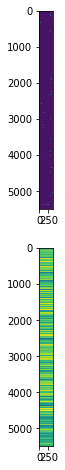

Itr 0, Obj 3405413503.968303
Itr 1, Obj 2505748894.712466
Itr 2, Obj 2031766611.178128
Itr 3, Obj 1723304125.875357
Itr 4, Obj 1499813060.530589
Itr 5, Obj 1327547508.715861
Itr 6, Obj 1189351651.685644
Itr 7, Obj 1075370843.830991
Itr 8, Obj 979440186.890125
Itr 9, Obj 897448976.107439
Itr 10, Obj 826515541.634501
Itr 11, Obj 764539724.817694
Itr 12, Obj 709943677.212445
Itr 13, Obj 661509749.647957
Itr 14, Obj 618281501.869438
Itr 15, Obj 579492250.507432
Itr 16, Obj 544521173.002346
Itr 17, Obj 512857479.210542
Itr 18, Obj 484077520.581143
Itr 19, Obj 457825791.816606
Itr 20, Obj 433803306.228175
Itr 21, Obj 411754332.417345
Itr 22, Obj 391460428.027351
Itr 23, Obj 372733775.053932
Itr 24, Obj 355411784.528474
Itr 25, Obj 339352163.112552
Itr 26, Obj 324431949.932227
Itr 27, Obj 310542025.369489
Itr 28, Obj 297586756.407387
Itr 29, Obj 285481649.631020
Itr 30, Obj 274151593.521407
Itr 31, Obj 263529970.166385
Itr 32, Obj 253557100.138041
Itr 33, Obj 244179479.064725
Itr 34, Obj 2353

[[ 4.75544781e+02 -9.70754524e+00  3.27898500e+00  4.45947185e+01
   4.31730196e+00  1.78814383e+01  1.43305576e+01  4.45532360e+00
   2.78642973e+01  1.88671266e+01  5.37754299e+00  5.19070117e-01
   3.28889409e+01  1.48115613e+01  9.96035234e+00  2.52646741e+01
   4.40315270e+00  1.14800508e+01 -2.30192788e+00  3.30121339e+01
  -1.07780600e+01  3.12090636e+01  4.75714303e+01  5.23073715e+01
  -4.21267626e+00  2.39339983e+01  4.31173796e+01  5.73308039e+01
   1.14459774e+01  3.08839816e+00]
 [-9.70754524e+00  4.26318677e+02 -6.23269452e-01 -8.47645850e+00
  -8.20666061e-01 -3.39891548e+00 -2.72396875e+00 -8.46879063e-01
  -5.29647430e+00 -3.58619830e+00 -1.02213836e+00 -9.86656088e-02
  -6.25146801e+00 -2.81535809e+00 -1.89327174e+00 -4.80226929e+00
  -8.37005114e-01 -2.18211495e+00  4.37550295e-01 -6.27485690e+00
   2.04871771e+00 -5.93218451e+00 -9.04230863e+00 -9.94250528e+00
   8.00727554e-01 -4.54936427e+00 -8.19568888e+00 -1.08973656e+01
  -2.17568008e+00 -5.87065158e-01]
 [ 3.2

KeyboardInterrupt: 

In [93]:
yeast_c_cutoff = NetREX(e_yeast_2, c_yeast_2, lmbda)
yeast_c_cutoff.NetREX_algorithm()

In [94]:
predicted = pd.DataFrame(yeast_c_cutoff.S, index=idx_prior2.index, columns=idx_prior2.columns)
predicted.head()

,MAL63,MATA1,MATA1-MATALPHA2-DIMER,TBP,TBP-TFIIA,TBP-TFIIA-TFIIB,TBP-TFIIB,YAL011W,YAL021C,YAL043C,...,YPR052C,YPR054W,YPR065W,YPR068C,YPR072W,YPR086W,YPR104C,YPR133C,YPR196W,YPR199C
YAL008W,1.421372,1.441092,1.220331,1.094461,0.111197,0.507365,1.893657,0.690380,1.184373,0.700379,...,1.089815,1.066879,1.085140,1.233755,0.860802,1.312261,1.008511,1.147372,1.329837,0.956196
YBR255W,0.069652,2.155323,-0.355514,2.943679,4.028154,-0.875460,-1.454534,32.476675,1.328541,0.000000,...,0.843644,0.264234,0.968397,1.781496,0.000000,0.458705,1.009357,1.612733,0.468013,0.194757
YGR131W,1.878394,0.981722,1.431216,2.043495,1.104344,2.510999,2.458907,0.751831,-0.357254,0.673843,...,0.324047,0.000000,0.918592,0.917254,0.063943,1.351711,0.525413,1.912559,2.002049,0.974241
YPL144W,2.071055,1.373004,0.435207,2.730159,2.120132,1.285655,0.619813,1.198253,0.263324,1.438773,...,0.742872,0.717979,40.986577,0.000000,0.447250,0.594258,0.246322,2.041831,1.840060,0.884648
YBR135W,2.133932,1.208168,1.261818,1.365607,1.193431,0.806789,0.388041,0.000000,1.225959,2.144071,...,43.277327,0.312485,0.931265,0.775988,1.277326,0.903271,0.476420,1.686588,1.324297,0.857591


In [ ]:
predicted.to_csv('../output/yeast_netrex_c_cutoff_morestrict_predicted_network', sep='\t')

In [95]:
x_trans_y = yeast_c_cutoff.X.T.dot(yeast_c_cutoff.Y)

In [97]:
x_tr_y_predicted = pd.DataFrame(x_trans_y, index=idx_prior2.index, columns=idx_prior2.columns)

In [ ]:
x_tr_y_predicted.to_csv('../output/yeast_netrex_c_cutoff_morestrict_x_tr_y', sep='\t')

In [98]:
x_tr_y_predicted.head()

,MAL63,MATA1,MATA1-MATALPHA2-DIMER,TBP,TBP-TFIIA,TBP-TFIIA-TFIIB,TBP-TFIIB,YAL011W,YAL021C,YAL043C,...,YPR052C,YPR054W,YPR065W,YPR068C,YPR072W,YPR086W,YPR104C,YPR133C,YPR196W,YPR199C
YAL008W,0.996248,0.996400,0.996383,0.996462,0.996464,0.996124,0.996418,0.996343,0.996339,0.996345,...,0.996806,0.996574,0.996704,0.996692,0.996626,0.996741,0.996592,0.996449,0.996462,0.996544
YBR255W,0.992548,0.992559,0.992703,0.992692,0.992571,0.992577,0.992550,0.992493,0.992549,0.992629,...,0.992785,0.992789,0.992723,0.992637,0.992676,0.992707,0.992784,0.992498,0.992359,0.992594
YGR131W,0.995302,0.995391,0.995379,0.995371,0.995467,0.994979,0.995376,0.995345,0.995352,0.995352,...,0.995780,0.995423,0.995739,0.995714,0.995592,0.995728,0.995511,0.995465,0.995479,0.995548
YPL144W,0.995528,0.995503,0.995412,0.995422,0.995428,0.995383,0.995489,0.995532,0.995511,0.995572,...,0.995577,0.995458,0.995562,0.995562,0.995608,0.995596,0.995535,0.995526,0.995560,0.995558
YBR135W,0.995285,0.995432,0.995343,0.995414,0.995455,0.995172,0.995509,0.995451,0.995438,0.995484,...,0.995652,0.995457,0.995606,0.995647,0.995542,0.995652,0.995523,0.995450,0.995467,0.995379


In [ ]:
import dill                            
filepath = './netrexruns'
dill.dump_session(filepath, byref=True)